# Normal with Fixed Variance

The model in this case is $P_{\theta} = N(\mu,1)$ with variance fixed at 1. Iteratively, only the mean is estimated $\hat{\mu}$ as the sample mean and synthetic samples generated from $N(\hat{\mu},1)$. Performance is measured by $E(\hat{\mu}_t - \mu_0)^2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# true distribution is N(3,1)
mu0 = 3.0
sigma0 = 1.0
model0 = mu0

In [2]:
def fit(X):
    '''
    X is of shape (n,)
    '''
    return X.mean()

def dist(model1, model2):
    '''
    models are mu
    '''
    
    return (model1 - model2)**2

def plot_avg(loss, ax, plot_traces=True):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    if plot_traces:
        for i in range(len(loss)):
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)

## Simulation Setups

We conduct 8 experiments:

No fresh data
1. $n_t=20$, $\alpha_t=0$, no accumulation
2. $n_t=20 t$, $\alpha_t=0$, no accumulation
3. $n_t=20 t^{3/2}$, $\alpha_t=0$, no accumulation
4. $n_t=20$, $\alpha_t=0$, accumulation over all past models

Fresh data

5. $n_t=20t$, $\alpha_t=0.1/t$, no accumulation
6. $n_t=20t$, $\alpha_t=0.1/t^{1/2}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1/t^{1/3}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1$, no accumulation

In [5]:
n0 = 20

def iterative_normal_mu(setting, T=100):
    nt_ = setting['nt_'] # n_t = n0 * (1+t)**nt_
    alpha0 = setting['alpha0']
    at_ = setting['at_'] # alpha_t = alpha0 / (1+t)**at_
    accu = setting['accu'] # True or False
    
    # first iteration
    X = np.random.normal(loc=model0, scale=1.0, size=n0)
    model = fit(X)

    loss = [dist(model0, model)]
    
    for t in range(T-1):
        n = int(n0 * (1+t)**nt_)
        alpha = alpha0 / (1+t)**at_
        
        if alpha > 0:
            prop = np.array([alpha, 1-alpha])
            m = np.random.multinomial(n, prop)
            if m[0]>0 and m[1]>0:
                X0 = np.random.normal(loc=model0, scale=1.0, size=m[0])
                X_ = np.random.normal(loc=model, scale=1.0, size=m[1])
                X1 = np.append(X0, X_)
            elif m[1]>0:
                X1 = np.random.normal(loc=model, scale=1.0, size=m[1])
            elif m[0]>0:
                X1 = np.random.normal(loc=model0, scale=1.0, size=m[0])
        else:
            X1 = np.random.normal(loc=model, scale=1.0, size=n)
            
        if accu:
            X = np.append(X, X1)
            model = fit(X)
        else:
            model = fit(X1)
        loss.append(dist(model0, model))
    return loss

settings = [
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1.5, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': True},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 1, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.5, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.33, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0, 'accu': False}
]

In [6]:
reps = 500
T=200

from tqdm import tqdm
from joblib import Parallel, delayed

losses = np.zeros((len(settings), reps, T))

for i, setting in enumerate(settings):
    results = Parallel(n_jobs=-1)(delayed(iterative_normal_mu)(setting=setting, T=T) for j in range(reps))
    losses[i] = np.array([results[j] for j in range(reps)])
    print(f'setting {i+1} done')

setting 1 done
setting 2 done
setting 3 done
setting 4 done
setting 5 done
setting 6 done
setting 7 done
setting 8 done


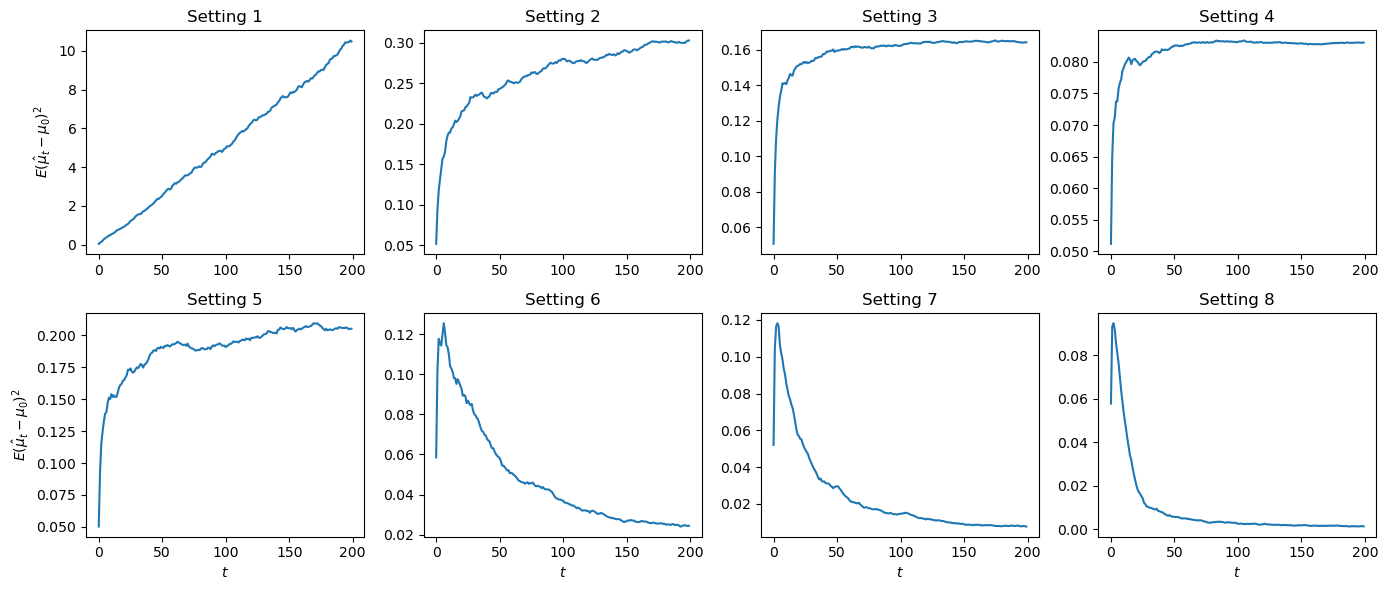

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

for r in range(2):
    for c in range(4):
        plot_avg(losses[4*r+c], ax[r,c], plot_traces=False)
        ax[r,c].set_title(f'Setting {4*r+c+1}')
ax[0,0].set_ylabel('$E (\hat{\mu}_t - \mu_0)^2$')
ax[1,0].set_ylabel('$E (\hat{\mu}_t - \mu_0)^2$')

for i in range(4):
    ax[1,i].set_xlabel('$t$')
plt.tight_layout()
plt.show()

In [3]:
def iterative_norm_syn(mu0, beta, T, fixed=True, accu=False):
    n = beta
    
    # first iteration
    X = np.random.normal(loc=mu0, scale=1.0, size=n)
    muhat = X.mean() 

    loss = [(muhat - mu0)**2]
    
    
    for t in range(T-1):
        if fixed is False:
            n = int(beta * (1+t)**1.5)
        X1 = np.random.normal(loc=muhat, scale=1.0, size=n)
        
        if accu is True:
            X = np.append(X, X1)
            muhat = X.mean() 
        else:
            muhat = X1.mean()
            
        loss.append((muhat - mu0)**2)
        
    return loss

In [4]:
reps = 1000
T = 100

from tqdm import tqdm
from joblib import Parallel, delayed

# fixed n
def f(i):
    return iterative_norm_syn(mu0, beta=20, T=T, fixed=True, accu=False)

results_syn1 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('fixed n finished')

# n growing
def f(i):
    return iterative_norm_syn(mu0, beta=20, T=T, fixed=False, accu=False)

results_syn2 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('inc n finished')

# accumulation
def f(i):
    return iterative_norm_syn(mu0, beta=20, T=T, fixed=True, accu=True)

results_syn3 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('accumulation finished')

fixed n finished
inc n finished
accumulation finished


In [5]:
syn1_loss_p1 = np.array([results_syn1[i] for i in range(reps)]) # shape (reps, T)

syn2_loss_p1 = np.array([results_syn2[i] for i in range(reps)])

syn3_loss_p1 = np.array([results_syn3[i] for i in range(reps)])

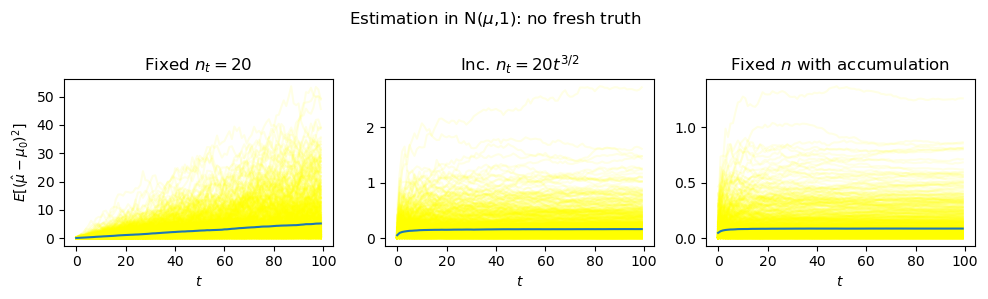

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

plot_avg(syn1_loss_p1, ax[0])
plot_avg(syn2_loss_p1, ax[1])
plot_avg(syn3_loss_p1, ax[2])

ax[0].set_ylabel('$E[(\hat{\mu}-\mu_0)^2]$')

ax[0].set_title('Fixed $n_t=20$')
ax[1].set_title('Inc. $n_t=20 t^{3/2}$')
ax[2].set_title('Fixed $n$ with accumulation')
for i in range(3):
    ax[i].set_xlabel('$t$')
    
plt.suptitle('Estimation in N($\mu$,1): no fresh truth')
plt.tight_layout()
plt.show()

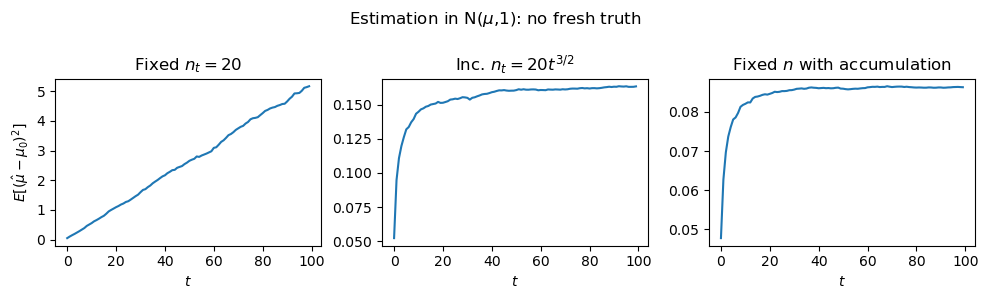

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

plot_avg(syn1_loss_p1, ax[0], plot_traces=False)
plot_avg(syn2_loss_p1, ax[1], plot_traces=False)
plot_avg(syn3_loss_p1, ax[2], plot_traces=False)

ax[0].set_ylabel('$E[(\hat{\mu}-\mu_0)^2]$')

ax[0].set_title('Fixed $n_t=20$')
ax[1].set_title('Inc. $n_t=20 t^{3/2}$')
ax[2].set_title('Fixed $n$ with accumulation')
for i in range(3):
    ax[i].set_xlabel('$t$')
    
plt.suptitle('Estimation in N($\mu$,1): no fresh truth')
plt.tight_layout()
plt.show()